# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("MSFT", start="1990-01-01", end="2022-02-21")

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.384520,53035200
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.386687,113774400
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.398060,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.388312,69566400
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.394269,58982400
...,...,...,...,...,...,...
2022-02-14,293.769989,296.760010,291.350006,295.000000,291.531281,36359500
2022-02-15,300.010010,300.799988,297.019989,300.470001,296.936951,27058300
2022-02-16,298.369995,300.869995,293.679993,299.500000,296.590363,29982100


In [ ]:
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

In [ ]:
scaled_data

array([[ 0.00563504],
       [ 0.02941149],
       [-0.02448979],
       ...,
       [-0.00322828],
       [-0.0292821 ],
       [-0.00963099]])

In [ ]:
# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



In [ ]:
training_data_len

6477

In [ ]:
train_data

array([[ 0.00563504],
       [ 0.02941149],
       [-0.02448979],
       ...,
       [ 0.00438897],
       [-0.01011956],
       [ 0.02184012]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################

#forecasting here did the stock price move up or down tomorrow
    # instead of having y_train be a percentage dif it shud just be did stock move up or down

# input size = this is the number of time lags, 2 = today and yesterdays price data to forecast tomorrow
input_size = 10
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > train_data[i-1, 0]:
        y_train.append(1)  # stock moved up
    else:
        y_train.append(0)  
        
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape x_train to match input shape of LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Now, we can build our RNN architecture using the Sequential model from Keras. We will use an LSTM layer with 50 units, followed by a dropout layer to prevent overfitting. Finally, we will add a dense layer with one unit and a sigmoid activation function to make the binary prediction.

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
203/203 [==============================] - 9s 15ms/step - loss: 0.6930 - accuracy: 0.5123
Epoch 2/50
203/203 [==============================] - 3s 15ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 3/50
203/203 [==============================] - 3s 17ms/step - loss: 0.6801 - accuracy: 0.5783
Epoch 4/50
203/203 [==============================] - 4s 21ms/step - loss: 0.6144 - accuracy: 0.6657
Epoch 5/50
203/203 [==============================] - 3s 15ms/step - loss: 0.5633 - accuracy: 0.7088
Epoch 6/50
203/203 [==============================] - 3s 15ms/step - loss: 0.5414 - accuracy: 0.7291
Epoch 7/50
203/203 [==============================] - 3s 16ms/step - loss: 0.5343 - accuracy: 0.7385
Epoch 8/50
203/203 [==============================] - 4s 20ms/step - loss: 0.5316 - accuracy: 0.7385
Epoch 9/50
203/203 [==============================] - 3s 15ms/step - loss: 0.5288 - accuracy: 0.7421
Epoch 10/50
203/203 [==============================] - 3s 15ms/step - loss: 0.5260 - accura

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]
x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)



51/51 [==============================] - 1s 5ms/step


<ipython-input-10-0ae27e7848c5>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  test_accuracy = np.mean(test_predicted_direction == test_actual_direction)


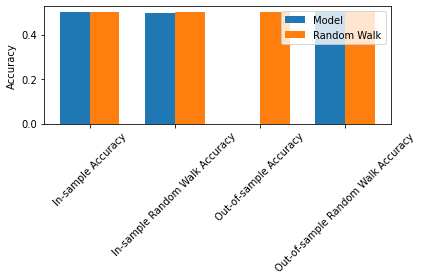

In [ ]:
# This line of code will calculate the predicted direction of the stock movement based on our binary forecast
predicted_direction = np.where(predictions > 0.5, 1, 0)

# In-sample accuracy
train_predicted_direction = predicted_direction[:training_data_len-input_size]
train_actual_direction = y_train
train_accuracy = np.mean(train_predicted_direction == train_actual_direction)

# In-sample random walk assumption accuracy
train_random_direction = np.random.randint(0, 2, size=len(train_actual_direction))
train_random_accuracy = np.mean(train_random_direction == train_actual_direction)

# Out-of-sample accuracy
test_predicted_direction = predicted_direction[training_data_len-input_size:]
test_actual_direction = np.where(y_test > 0, 1, 0)
test_accuracy = np.mean(test_predicted_direction == test_actual_direction)

# Out-of-sample random walk assumption accuracy
test_random_direction = np.random.randint(0, 2, size=len(test_actual_direction))
test_random_accuracy = np.mean(test_random_direction == test_actual_direction)

import matplotlib.pyplot as plt

labels = ['In-sample Accuracy', 'In-sample Random Walk Accuracy', 'Out-of-sample Accuracy', 'Out-of-sample Random Walk Accuracy']
model_accuracies = [train_accuracy, train_random_accuracy, test_accuracy, test_random_accuracy]
random_walk_accuracies = [0.5, 0.5, 0.5, 0.5]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, model_accuracies, width, label='Model')
rects2 = ax.bar(x + width/2, random_walk_accuracies, width, label='Random Walk')

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

fig.tight_layout()

plt.show()


#5.) Write an observation/conclusion about the graphs from Q4 and Q3

- For the bar charts in question 3, we can see that for in-sample accuracy, our model performed very similarly in terms of accuracy to the random walk. However, for out-of-sample accuracy, we can see that our model performed very poorly compared to the random walk. This can be seen by discrepancy between the bars for out of sample accuracy, as the bar for the model is nonexistent. This illustrates that our model did not outperform the random walk.


# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold

In [ ]:
def create_model(lag):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(lag, 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(50))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return(model)

In [ ]:
param_grid = {'batch_size': [10, 20, 32],
              'epochs': [10, 20],
              'lag': [5, 10, 20]}

In [ ]:
model = KerasRegressor(build_fn=create_model, verbose=0)

<ipython-input-22-9f3192b984b9>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [ ]:
# This code performs the grid search over the hyperparameters using 3-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_lea

Best: -0.519818 using {'batch_size': 20, 'epochs': 10, 'lag': 10}


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.519818 using {'batch_size': 20, 'epochs': 10, 'lag': 10}
